In [1]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt

In [2]:
H = np.array([[1, 1, 0, 1, 0, 0], 
              [0, 1, 1, 0, 1, 0], 
              [1, 0, 0, 0, 1, 1], 
              [0, 0, 1, 1, 0, 1]])
n = 1440000

SNR = list(range(0,20,2))

print(SNR)  

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18]


## Generate Input/Transmission bits

In [3]:
n1 = n//6
c = np.zeros((n1, 6))
i = 0

while i<n1:

    # random input generator
    randBinList = lambda n: [random.randint(0,1) for b in range(1,n+1)]
    strin = randBinList(n)
    
    inbits = np.array([int(num) for num in strin]).reshape((n1,6)) #kx6
    temp = np.sum(np.matmul(H, inbits.transpose())%2, axis=0)

    for j in range(temp.shape[0]):
        if temp[j]==0:
            c[i] = inbits[j]
            i += 1
            if i >= n1:
                break

assert(np.sum(np.matmul(H,c.transpose())%2)==0)
print("No. of 6-bit signals sent:", c.shape[0])

No. of 6-bit signals sent: 240000


In [4]:
msg_node = 6 # bit_node
chk_node = 4 # parity node

## Iteration parameters
max_iter = 5

## Monte Carlo Simulations - I
- maps transmitted signal value to bit

In [ ]:
## equations in use

# k = Es/N0
# N0 = 2*(sigma**2)
# r = 4*y*Es/N0   #where y = (2*y[w]-1)
# SNR = 10*np.log10(k)
        

In [6]:
error = [0]*len(SNR)
s = 2*c - 1

for l in range(len(SNR)):
    sigma = 10**(-SNR[l]/20)
    randNoiseBinList = lambda n: [random.gauss(0,sigma) for b in range(1,n+1)]
    noise = np.array([num for num in randNoiseBinList(n)]).reshape((n//6,6)) #kx6
    y = s + noise  #6xk
    
    # bpsk mapping converting -ve bits to 0 and +ve to 1
    y = y > 0 

    # convert decimal form to int
    y = np.int64(y)
    k = 2/(sigma**2)
    
    for w in range(c.shape[0]):

        r = 2*(2*y[w]-1)/(sigma**2)  # -1,1 mapping
    
        # message from bit node to chk node
        M = np.zeros([4,6])

        # message from chk node to bit node
        E = np.zeros([4,6])

        L = np.zeros(r.shape)
        z = np.zeros(r.shape)

        # for j in range(chk_node):
        for i in range(msg_node):
            M[:,i] = H[:,i] * r[i]
       

        curr_iter = 0
        while True:
            curr_iter += 1
            tanhM = np.tanh(M/2)
            for j in range(chk_node):
                t = 1
                for i in range(msg_node):
                    if H[j,i]:
                        t *= tanhM[j,i]

                # modify for sparse matrices 
                # store indices in hashmap for quick access
                for i in range(msg_node):
                    if H[j,i]:
                        prod_tanhM = t/tanhM[j,i]
                        E[j,i] = np.log((1 + prod_tanhM)/(1 - prod_tanhM))
                    else:
                        E[j,i] = 0

            for i in range(msg_node):
                L[i] = r[i] + np.sum(E[:,i])
                z[i] = 0 if L[i]>0 else 1
        #     z = [0 if L[i]>0 else 1 for i in range(msg_node)]


            if curr_iter >= max_iter or np.all(np.dot(H,z)%2==0):
                break
            else:
                for i in range(msg_node):
                    t = np.sum(E[:,i])
                    for j in range(chk_node):
                        if H[j,i]:
                            M[j,i] = (t - E[j,i]) + r[i]
        error[l] = error[l] + np.sum(np.sum(abs(z-c[w])))
    

/Users/i511980/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log
/Users/i511980/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in double_scalars
/Users/i511980/miniconda3/envs/ml/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


No. of error bits: [576585.0, 440645.0, 274794.0, 122374.0, 34479.0, 4489.0, 192.0, 4.0, 0.0, 0.0]
BPSK bit error rate [ -3.97499152  -5.14273646  -7.19355246 -10.70673336 -16.20807831
 -25.06212887 -38.75061263 -55.56302501         -inf         -inf]
SNR : [0, 2, 4, 6, 8, 10, 12, 14, 16, 18]


/Users/i511980/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


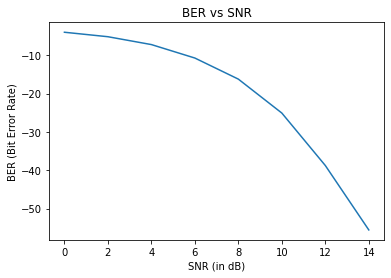

In [7]:
print("No. of error bits:", error)
error = np.divide(error,n)
error = 10*np.log10(error)
print("BPSK bit error rate", error)
print("SNR :", SNR)
 
# plotting the points 
plt.plot(SNR, error)
 
plt.xlabel('SNR (in dB)')     
plt.ylabel('BER (Bit Error Rate)')
plt.title('BER vs SNR')
 
plt.show()

## Monte Carlo Simulations - II
- Since we are transmitting bits over a AWGN noisy channel, the received bits are no more bits because of the Gaussian nature of noise. 
- This MC Simulation lets the transmitted signal be a float instead of mapping it to a bit.
- Again, this is intuitively wrong, as we are changing the nature of transmission channel by transmitting float values in place of bits. And hence we get a curve that is not as smooth as the one obtained above.

In [8]:
error = [0]*len(SNR)
s = 2*c - 1

for l in range(len(SNR)):
    sigma = 10**(-SNR[l]/20)
    randNoiseBinList = lambda n: [random.gauss(0,sigma) for b in range(1,n+1)]
    noise = np.array([num for num in randNoiseBinList(n)]).reshape((n//6,6)) #kx6
    y = s + noise  #6xk
    
    k = 2/(sigma**2)
    
    for w in range(c.shape[0]):
        r = 2*y[w]/(sigma**2)  
        
        # message from bit node to chk node
        M = np.zeros([4,6])

        # message from chk node to bit node
        E = np.zeros([4,6])

        L = np.zeros(r.shape)
        z = np.zeros(r.shape)

        # for j in range(chk_node):
        for i in range(msg_node):
            M[:,i] = H[:,i] * r[i]
       

        curr_iter = 0
        while True:
            curr_iter += 1
            tanhM = np.tanh(M/2)
            for j in range(chk_node):
                t = 1
                for i in range(msg_node):
                    if H[j,i]:
                        t *= tanhM[j,i]

                # modify for sparse matrices 
                # store indices in hashmap for quick access
                for i in range(msg_node):
                    if H[j,i]:
                        prod_tanhM = t/tanhM[j,i]
                        E[j,i] = np.log((1 + prod_tanhM)/(1 - prod_tanhM))
                    else:
                        E[j,i] = 0

            for i in range(msg_node):
                L[i] = r[i] + np.sum(E[:,i])
                z[i] = 0 if L[i]>0 else 1
        #     z = [0 if L[i]>0 else 1 for i in range(msg_node)]


            if curr_iter >= max_iter or np.all(np.dot(H,z)%2==0):
                break
            else:
                for i in range(msg_node):
                    t = np.sum(E[:,i])
                    for j in range(chk_node):
                        if H[j,i]:
                            M[j,i] = (t - E[j,i]) + r[i]
        error[l] = error[l] + np.sum(np.sum(abs(z-c[w])))

/Users/i511980/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log
/Users/i511980/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in double_scalars
/Users/i511980/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in double_scalars


No. of error bits: [878091.0, 853034.0, 793331.0, 681774.0, 510130.0, 302264.0, 114552.0, 14651.0, 3.0, 0.0]
BPSK bit error rate [ -2.14822966  -2.27396151  -2.58908067  -3.24722057  -4.50681628
  -6.77976067 -10.99359816 -19.92495224 -56.81241237         -inf]
SNR : [0, 2, 4, 6, 8, 10, 12, 14, 16, 18]


/Users/i511980/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


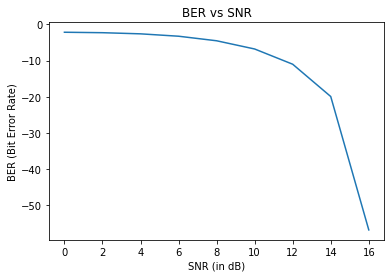

In [9]:
print("No. of error bits:", error)
error = np.divide(error,n)
error = 10*np.log10(error)
print("BPSK bit error rate", error)
print("SNR :", SNR)
 
# plotting the points 
plt.plot(SNR, error)
 
plt.xlabel('SNR (in dB)')
plt.ylabel('BER (Bit Error Rate)')
plt.title('BER vs SNR')
 
plt.show()